In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Distances")
# Pkg.add("Random")
# Pkg.add("Distributions")
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Fontconfig")

In [2]:
using Plots
using Compose, Cairo, Fontconfig

In [23]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/out.jl")
include("./src/lagrange.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


In [5]:
trips = loadGTFS("..\\data\\Nanaimo-GTFS");
size(trips)

(637, 10)

In [26]:
# subset = subsetGTFS(trips, 9, randomSeed = 12) # good example w/ 2 vehicles
# subset = subsetGTFS(trips, 10, randomSeed = 12) # good example w/ 2 vehicles
subset = subsetGTFS(trips, 100, randomSeed = 3);
# subset = subsetGTFS(trips, 10, randomSeed = 10)
instance = VSPInstance(subset);
vsp_model = VSPModel(instance; warmStart = true, isInt = true, multiObj = false)
# vsp_model_nonint = VSPModel(instance; isInt = false, multiObj = false)
mcf_model = MCFModel(instance)
vsp_solution = solve!(vsp_model);
# vsp_solution_nonint = solve!(vsp_model_nonint)
mcf_solution = solve!(mcf_model);

numTrips = 100
numVehicles = 10.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 1460.6618702955973
solve_time(mod.model) = 3.422999858856201


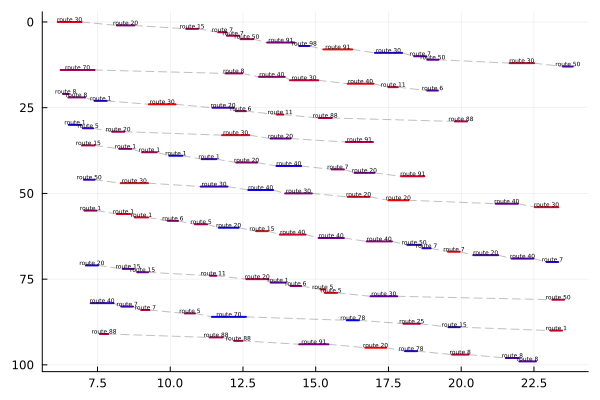

In [27]:
plotVSP_time(vsp_solution)

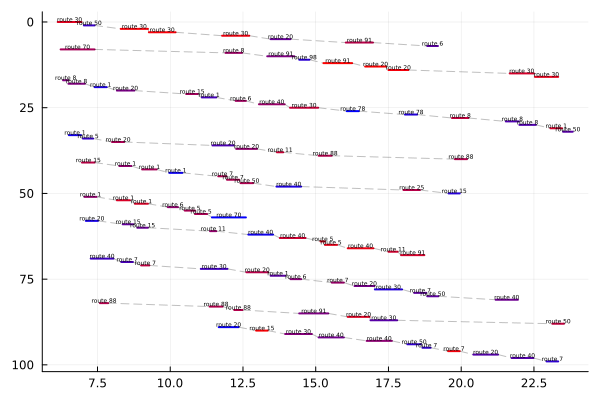

In [28]:
plotVSP_time(mcf_solution)

In [35]:
describe(solutionStats(mcf_solution))

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,duration,13.3833,5.55,13.375,17.5167,0,Float64
2,num_trips,10.0,7.0,9.5,16.0,0,Float64
3,in_service,0.445987,0.256008,0.456508,0.648648,0,Float64


In [6]:
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-instance.png", 16cm, 16cm), plotVSP(instance))
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-mcf_solution.png", 16cm, 16cm), plotVSP(mcf_solution))
# draw(PNG(".\\imgs\\VSP-PD-$(instance.n-1)-mcf_solution.png", 16cm, 16cm), plotVSP(vsp_solution_nonint))

## Leaflet

In [1]:
using Leaflet
using GeoInterface

WebIO._IJuliaInit()

In [7]:
geom = GeoInterface.geometry([(-123.95, 49.175), (-123.95, 49.17), (-123.9, 49.175)])
@show geom
# layers = Leaflet.Layer(ls; color = :orange)
# provider = Leaflet.CARTO()
# m = Leaflet.Map(;
#     layers = layers,
#     provider = provider,
#     zoom = 12,
#     center = [49.175, -123.95]
# )

geom = nothing


## Bender's decomposition

In [9]:
# fs = FirstStageProblem(instance; timeLimit = 10)
# add_benders_callback!(fs)
# bd_solution = solve!(fs);
# @show mean(lp_callback_runtimes)
# @show mean(get_p_callback_runtimes);
# MOI.get(fs.model, MOI.RelativeGap())
# plotVSP(bd_solution)

## 10 sec Opt Gap

In [11]:
# instance_sizes = 100:100:500
# opt_gap_IP = []
# opt_gap_BD = []

# for size in instance_sizes
#     sum_IP = 0
#     sum_BD = 0
#     for i in 1:5
#         subset = subsetGTFS(trips, size, randomSeed = i)
#         instance = VSPInstance(subset)
#         model_IP = VSPModel(instance, isInt = true, multiObj = false, timeLimit = 10)
#         model_BD = FirstStageProblem(instance, timeLimit = 10)
#         add_benders_callback!(model_BD)
#         sol_IP = solve!(model_IP);
#         sol_BD = solve!(model_BD);
#         sum_IP += MOI.get(model_IP.model, MOI.RelativeGap())
#         sum_BD += MOI.get(model_BD.model, MOI.RelativeGap())
#     end
#     push!(opt_gap_IP, sum_IP / 5)
#     push!(opt_gap_BD, sum_BD / 5)
# end
@show [opt_gap_IP opt_gap_BD]

[opt_gap_IP opt_gap_BD] = [6.031947682607448e-6 0.1629275916113045; 0.027256919099971622 0.47132052625010956; 0.526180825699331 0.768839649480148; 0.7067324202226736 0.8463141117589137]


4×2 Matrix{Float64}:
 6.03195e-6  0.162928
 0.0272569   0.471321
 0.526181    0.76884
 0.706732    0.846314

## Lagrange relaxation

In [51]:
LR = LagrangeRelaxation(instance)

for i ∈ 1:100
    status = update!(LR)
    if status
        println(i)
        break
    end
end

Solution found within 1% optimality gap.
3


In [60]:
# plot([LR.UB LR.LB])
# hline!([objectiveValue(vsp_solution.x, vsp_solution.s, instance.C, instance.M)])
# plot(LR.opt_gap, ylims = [0, 1])
# LR.λ
# println(
#     "vsp: ",
#     sum(LR.x[LR.best_idx[1]] .+ vsp_solution.x .> 1) / sum(vsp_solution.x),
#     "; mcf: ",
#     sum(LR.x[LR.best_idx[1]] .+ mcf_solution.x .> 1) / sum(mcf_solution.x)
# )
# (minimum(LR.UB) .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# (LR.UB[1] .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# LR.s_adj
# plotVSP(instance, LR.x[LR.best_idx[1]], LR.s_adj[LR.best_idx[1]])

## solve times

In [8]:
# solve times
# instance_sizes = 20:20:200
# sol_times_LP = []
# sol_times_IP = []
# sol_times_BD = []

# for size in instance_sizes
#     sum_LP = 0
#     sum_IP = 0
    # sum_BD = 0
    # for i in 1:5
    #     subset = subsetGTFS(trips, size, randomSeed = i)
    #     instance = VSPInstance(subset)
    #     model_LP = VSPModel(instance, isInt = false, multiObj = false)
    #     model_IP = VSPModel(instance, isInt = true, multiObj = false)
        # model_BD = FirstStageProblem(instance)
        # add_benders_callback!(model_BD)
        # sol_LP = solve!(model_LP);
        # sol_IP = solve!(model_IP);
        # sol_BD = solve!(model_BD);
        # sum_LP += sol_LP.solve_time
        # sum_IP += sol_IP.solve_time
        # sum_BD += sol_BD.solve_time
    # end
    # push!(sol_times_LP, sum_LP / 5)
    # push!(sol_times_IP, sum_IP / 5)
    # push!(sol_times_BD, sum_BD / 5)
# end
# plot(
#     instance_sizes,
#     [sol_times_LP sol_times_IP];
#     xlabel = "number of trips",
#     ylabel = "solve time",
#     title = "LP, and IP solution times",
#     label = ["LP" "IP"]
# )
# png(".\\imgs\\VSP-PD-solve_times-BD")

## Pareto frontier

In [29]:
# Pareto frontier
# mod = vsp_model.model
# used_vehicles = [round(sum(value.(vsp_model.x[1, :]; result = i)); digits = 3) for i in 1:result_count(mod)]
# ideal_point = objective_bound(mod)
# pareto_plot = hline([ideal_point[2]]; color = :red, lw = 2, label = "", ylims = [1300, 1600], xlims = [-0.2, 7])
# vline!([ideal_point[1]]; color = :red, lw = 2, label = "objective bounds")
# Plots.scatter!(
#     [objective_value(mod; result = i)[1] for i in 1:result_count(mod)],
#     [objective_value(mod; result = i)[2] for i in 1:result_count(mod)];
#     xlabel = "delay",
#     ylabel = "cost",
#     title = "# trips: $(instance.n-1)",
#     label = "fleet used",
# )
# for i in 1:result_count(mod)
#     y = objective_value(mod; result = i)
#     Plots.annotate!(y[1], y[2] + 10, (used_vehicles[i], 10))
# end
# png(".\\imgs\\VSP-PD-$(instance.n-1)-pareto")
# pareto_plot